In [33]:
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.transforms import transforms
import torch.nn.functional as F
import time

In [34]:
cuda_available = torch.cuda.is_available()
cuda_available

True

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Initializing parameter

In [36]:
input_size = 784  # 28x28 pixels
hidden_sizes = [200, 150, 100, 80]
output_size = 10
batch_size = 100
learning_rate = 0.01
num_epochs = 20

## Loading the dataset using Pytorch Dataset and Data Loader

In [37]:
transform = transforms.Compose([transforms.ToTensor()])
batch_size = 100

In [38]:
train_dataset = torchvision.datasets.MNIST('./content', train=True, download=True, transform=transform)

test_dataset= torchvision.datasets.MNIST('./content', train=False, download=False, transform=transform)

In [39]:
train_dataloader=torch.utils.data.DataLoader(dataset=train_dataset,
                                             batch_size=100,shuffle=True)

test_dataloader=torch.utils.data.DataLoader(dataset=test_dataset,
                                             batch_size=100,shuffle=True)

In [40]:
data=iter(train_dataloader)
samples,labels=next(data)
print(f"number of samples{samples.shape}")
print(f"number of labels {labels.shape}")

number of samplestorch.Size([100, 1, 28, 28])
number of labels torch.Size([100])


## Saving Images from dataset

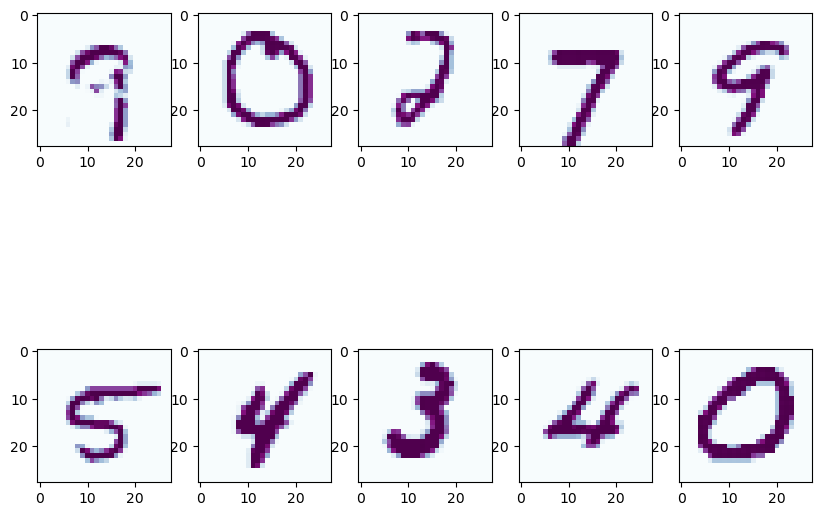

In [41]:
plt.figure(figsize=(10,8))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(samples[i][0],cmap='BuPu')
plt.savefig('numbers.png')

## Defining training pipeline

In [42]:
class MNIST(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MNIST, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(hidden_sizes)):
            if i == 0:
                self.layers.append(nn.Linear(input_size, hidden_sizes[i]))
            else:
                self.layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [43]:
mnist_model = MNIST(input_size, hidden_sizes, output_size)

# Move the model to GPU if available
if cuda_available:
    mnist_model = mnist_model.to('cuda')

In [44]:
print(mnist_model.parameters)

<bound method Module.parameters of MNIST(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=150, bias=True)
    (3): ReLU()
    (4): Linear(in_features=150, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=80, bias=True)
    (7): ReLU()
    (8): Linear(in_features=80, out_features=10, bias=True)
  )
)>


### Constructing loss and optimize for the model

In [45]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

## Train the model

In [46]:
start_time = time.time() 

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        # Move data to GPU if available
        if cuda_available:
            images = images.reshape(-1, input_size).to('cuda')
            labels = labels.to('cuda')

        # Forward pass
        output = mnist_model(images)

        # Calculate the loss
        batch_loss = loss_function(output, labels)

        # Backpropagation and optimization
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        # Print progress
        if (i + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Step {i + 1}/{len(train_dataloader)}, Loss: {batch_loss.item()}")

    # Adjust learning rate at the end of each epoch
    scheduler.step()

end_time = time.time()  # Record end time
training_duration = end_time - start_time  # Calculate training duration in seconds

print(f"Training completed in {training_duration:.2f} seconds")  # Print training duration

Epoch 1/20, Step 100/600, Loss: 0.2117374986410141
Epoch 1/20, Step 200/600, Loss: 0.23246866464614868
Epoch 1/20, Step 300/600, Loss: 0.14274489879608154
Epoch 1/20, Step 400/600, Loss: 0.2780449688434601
Epoch 1/20, Step 500/600, Loss: 0.44769448041915894
Epoch 1/20, Step 600/600, Loss: 0.141034796833992
Epoch 2/20, Step 100/600, Loss: 0.392310231924057
Epoch 2/20, Step 200/600, Loss: 0.14122778177261353
Epoch 2/20, Step 300/600, Loss: 0.09450966119766235
Epoch 2/20, Step 400/600, Loss: 0.07779156416654587
Epoch 2/20, Step 500/600, Loss: 0.13369514048099518
Epoch 2/20, Step 600/600, Loss: 0.23922473192214966
Epoch 3/20, Step 100/600, Loss: 0.19596943259239197
Epoch 3/20, Step 200/600, Loss: 0.11015963554382324
Epoch 3/20, Step 300/600, Loss: 0.1086484044790268
Epoch 3/20, Step 400/600, Loss: 0.04754560440778732
Epoch 3/20, Step 500/600, Loss: 0.10292103886604309
Epoch 3/20, Step 600/600, Loss: 0.04603995010256767
Epoch 4/20, Step 100/600, Loss: 0.049572981894016266
Epoch 4/20, Step 2

### Check model accuracy

In [47]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        if cuda_available:
            images = images.reshape(-1, input_size).to('cuda')
            labels = labels.to('cuda')

        outputs = mnist_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = (correct / total) * 100

In [48]:
accuracy

98.08

## Result prediction

In [49]:
# Result prediction
predicted = []

with torch.no_grad():
    for images, labels in test_dataloader:
        if cuda_available:
            images = images.reshape(-1, input_size).to('cuda')

        output = mnist_model(images)
        _, batch_predictions = torch.max(output, 1)
        predicted.extend(batch_predictions.cpu().numpy())

# Print the first 10 predictions
print("First 10 Predictions:", predicted[:10])


First 10 Predictions: [9, 1, 0, 2, 8, 0, 1, 2, 4, 7]
